#  <h1><center>**Super Market Order Analytics based on Shopping Trends**</center></h1>

<img src="analytics.png" height="1000" width="1200">

## **Table of Contents**

1. Abstract

2. Introduction

3. Import libraries and reading csv's

4. Data Preparation and Data Cleaning
   
5. Exploratory Data Analysis

6. Using Word2Vec

# **1. Abstract**

<img src="image.jpg">

Super Market Order Analysis is a modelling technique based upon the hypothesis that if you purchase a specific group of items, you are probably going to purchase another group of items.
For example, if you are in an Irish pub and you buy a pint of beer and for some reason you decide not to buy a bar meal, you are more likely to buy chips simultaneously than someone who didn't buy a dip.
In this analysis, a forecasting model is developed using machine learning algorithms to improve the accurate forecasts of product sales.

## The aim of this project is to predict the products the customer is most likely to buy in their next order based on the products which have been purchased previously.

# **2. Introduction**

This is also a Kaggle competition and the participants were supposed to foresee the next item which would be purchased by the customer. The competition was called: Instacart Market Basket Analysis, Which items will an Instacart customer buy again?
After choosing products through the Instacart app, individual customers review your order and do the in-store shopping and deliver the groceries for you at your doorstep.

In order to predict the sales we have compared different models like Word2Vec, Apriori analysis, Random Forest and XGBoost.
Further to enhance the outcomes and results we have used LightGBM. 
The data is in six different files having various types of data.

#### Predictive Analytics is not new in this era of technological advancement. Utilizing certain machine learning algorithms and  Tensor Flows we have performed certain exploratory data analytics to figure out simple answers about the customer behavior. A great deal has been done on the kernels in Kaggle. We have attempted to change and stretch out on certain pieces to discover more from the dataset.

# **3. Importing libraries and reading csv's**

The libraries that we will be using are:

**Numpy** : NumPy is a library for the Python programming language, adding support for large, multi-dimensional   arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.


**Pandas** :  Pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.


**Matplotlib** : Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.


**Scikit-learn** : Scikit-learn is a machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.


**Keras** : Keras is a deep learning library that: Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility). Supports both convolutional networks and recurrent networks, as well as combinations of the two.

We shall be loading all the above libraries and several of their features which we will be using.

#### **List of files used**

* **Aisles.csv** – This dataset contains the listing of all the aisles present in the stors based on the products.
* **Departments.csv** – This dataset contains the listing of all the departments present in the store by products types. 
  (eg. Frozen foods, Bakery etc.)
* **Order_Product_Prior** – It has details of all the previous customer orders.
* **Order_Product_Train.csv** – This dataset contains information about the products (product_id) that were ordered by the         customers. It also contains information about the order (add_to_cart_order) which tells us the products that were put into       the cart and the information if the product was re-ordered (1) or not (0).  
* **Orders.csv** – It is the main table containing details about the customer orders and also tells which record belongs to         which table, train, prior or test.
* **Products.csv** – This dataset contains the listing of all the products with their product_id. It also contains the aisles     and the departments that are included.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import gensim
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

#Loading all the csv files

df_aisles = pd.read_csv("aisles.csv")
df_departments = pd.read_csv("departments.csv")
df_order_products_prior = pd.read_csv("order_products__prior.csv")
df_order_products_train = pd.read_csv("order_products__train.csv")
df_orders = pd.read_csv("orders.csv")
df_products = pd.read_csv("products.csv")

# **4. Data Preperation and Cleaning**

In [4]:
#Reading the orders.csv file
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
#Counting the number of rows and columns in orders.csv
df_orders.shape

(3421083, 7)

In [6]:
#Finding if the dataset has any null values
df_orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

* In the current dataset, there is a column called eval_set. This gives information corresponding to which csv (train or test) is the column related to. We then take the count to train.

# **5. Exploratory Data Analysis**

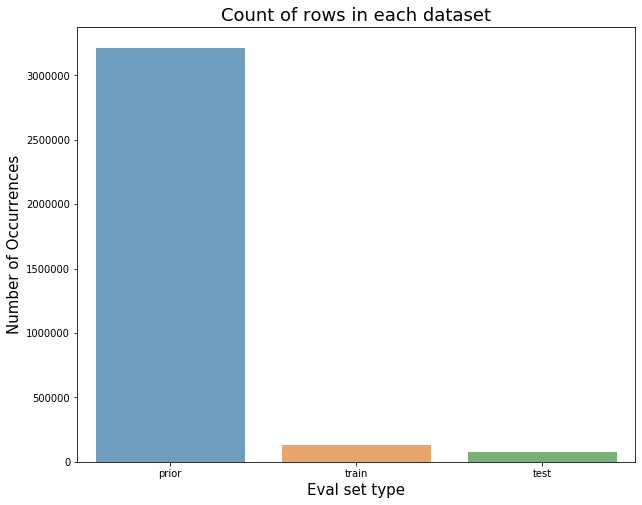

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


In [7]:
#Count no. of rows in each dataset
cnt_srs = df_orders.eval_set.value_counts()
plt.figure(figsize=(10,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.7)
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Eval set type', fontsize=15)
plt.title('Count of rows in each dataset', fontsize=18)
plt.show()
print(cnt_srs)

* From the above graph, there have been a total of 3214874 orders and 131209 orders have been provided for training the model and we need to predict for 75000.

In [8]:
#Finding number of customers
def get_unique_count(x):             ## Defining a function to get unique count for user_id from orders.csv
    return len(np.unique(x))

cnt_srs = df_orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

#### There are total 206209 customers in total. We inferred this information using the groupby for user_id and getting the unique count function.

##### Validating Dataset: Information has been provided that the prior orders for any customer ranging between 4 to 100 is given. Validating the same below :

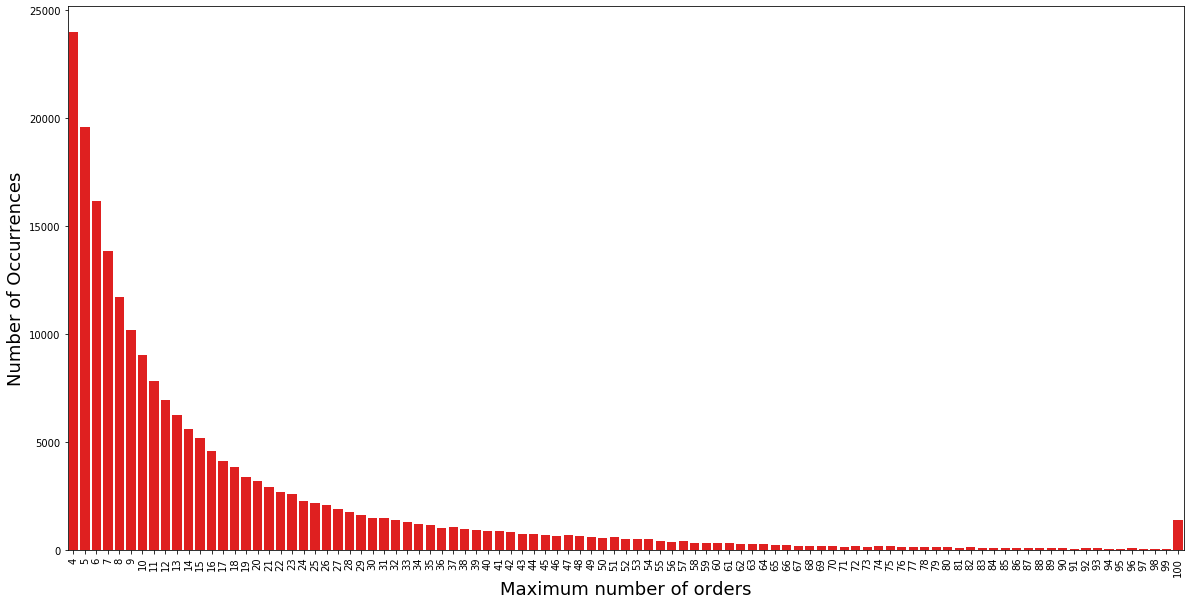

In [9]:
#Validating prior order range
cnt_srs = df_orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

#Bar-graph for the order-reorder counts
plt.figure(figsize=(20,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1.0, color = 'red')
plt.ylabel('Number of Occurrences', fontsize=18)
plt.xlabel('Maximum number of orders', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

As per the graph, the minimum number of previous orders is 4 and maximum is 100.

#### To know more about the customer ordering behaviour pattern, we analyze which day of the week has maximum number of orders.

In [10]:
#Changing the data labels into name of days of weeks
import calendar
days=[]

In [11]:
for i in df_orders['order_dow']:
    days.append(calendar.day_name[i])

In [12]:
#Adding another column for day-name of the week as per the number
df_orders['converted_dow']=days

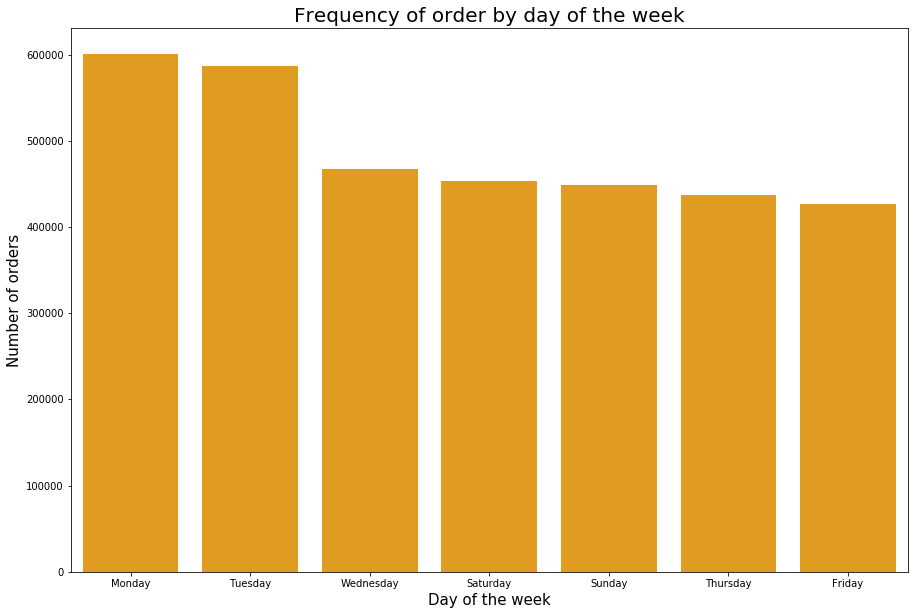

order_dow
0    600905
1    587478
2    467260
3    436972
4    426339
5    453368
6    448761
Name: order_id, dtype: int64

In [14]:
#Finding out the busiest day of the week
plt.figure(figsize=(15,10))
sns.countplot(x="converted_dow", data=df_orders, order=df_orders['converted_dow'].value_counts().index, color='orange')
plt.ylabel('Number of orders', fontsize=15)
plt.xlabel('Day of the week', fontsize=15)
plt.title("Frequency of order by day of the week", fontsize=20)
plt.show()
cnt_dow = df_orders.groupby('order_dow')['order_id'].aggregate(get_unique_count)
cnt_dow

* From the above plot, we infer that on Monday and Tuesday, the maximum number of orders are being placed. We can also understand that that most of the customers tend to order during the weekend and then orders tend to go down.


#### Next, We try to analyze and find out the time of the day when maximum orders are being placed like morning, afternoon etc. 

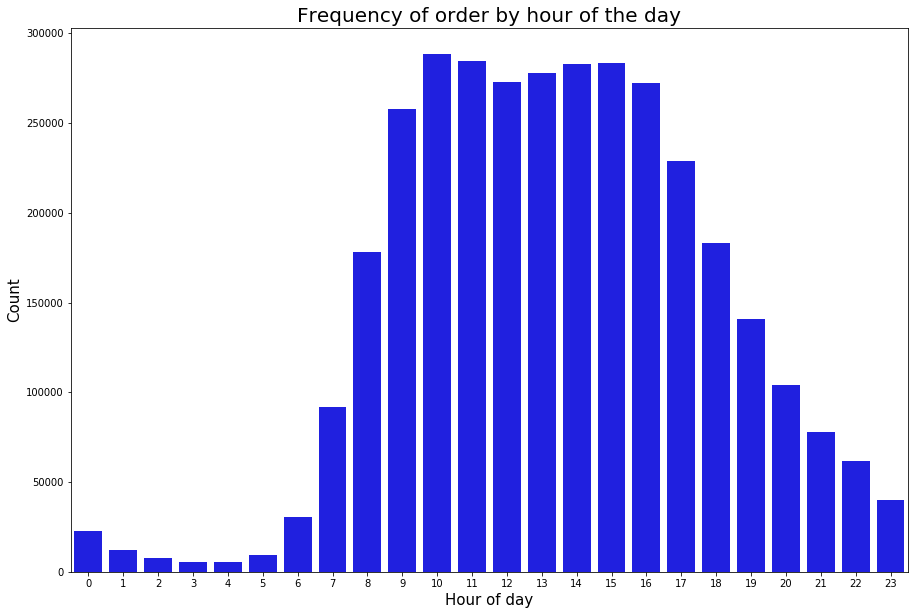

order_hour_of_day
0      22758
1      12398
2       7539
3       5474
4       5527
5       9569
6      30529
7      91868
8     178201
9     257812
10    288418
11    284728
12    272841
13    277999
14    283042
15    283639
16    272553
17    228795
18    182912
19    140569
20    104292
21     78109
22     61468
23     40043
Name: order_id, dtype: int64

In [15]:
#Figuring out which time of the day is the busiest
plt.figure(figsize=(15,10))
sns.countplot(x="order_hour_of_day", data=df_orders, color='blue')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Hour of day', fontsize=15)
plt.title("Frequency of order by hour of the day", fontsize=20)
plt.show()
cnt_hod = df_orders.groupby('order_hour_of_day')['order_id'].aggregate(get_unique_count)
cnt_hod

###### The peak hours for ordering are during 10:00 AM to 3:00 PM on Monday and Tuesday. Plotting a heat map to make it more clear.

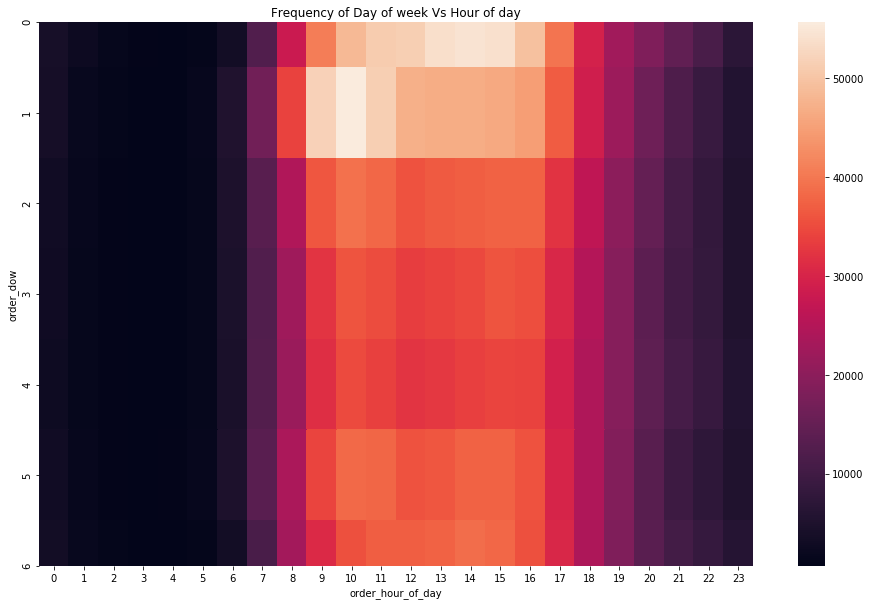

In [16]:
#Heat-map for the intersection of the day of week and hour of day
grouped_df = df_orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(16,10))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

### Analyzing the time period for reordering using the column called days_since_prior order.

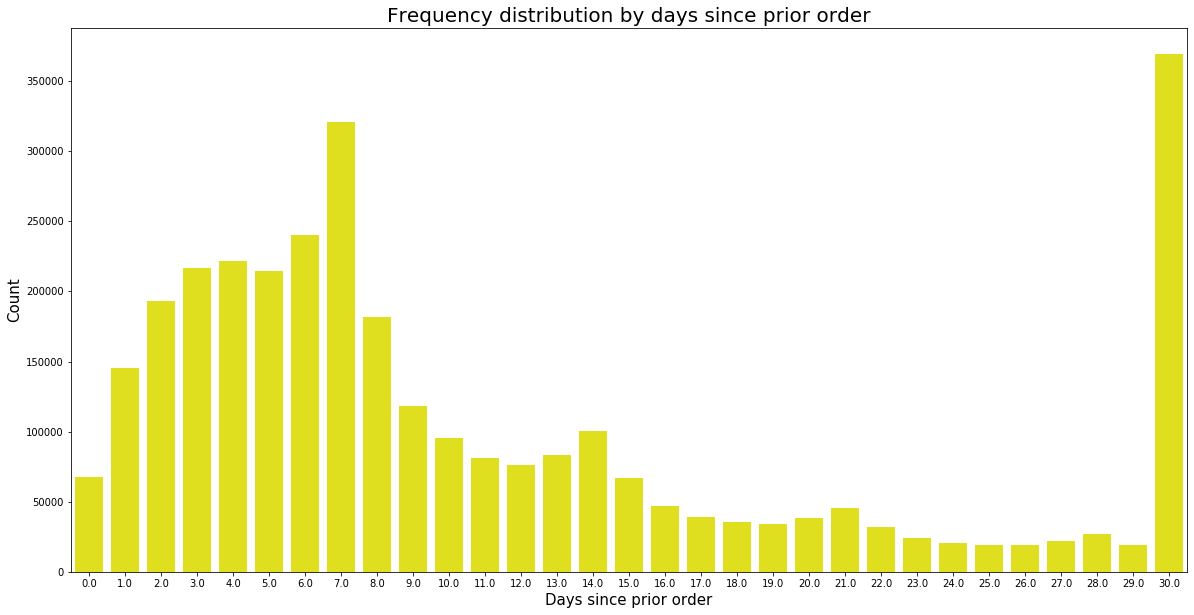

In [17]:
#Finding out after how many days an order is reordered
plt.figure(figsize=(20,10))
sns.countplot(x="days_since_prior_order", data=df_orders, color='yellow')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Days since prior order', fontsize=15)
plt.title("Frequency distribution by days since prior order", fontsize=20)
plt.show()

* Analysis: Customers tend to reorder after a period of 7 days (weekly) or 30 days (monthly).

In [18]:
# Percentage of re-orders in prior dataset
df_order_products_prior.reordered.sum() / df_order_products_prior.shape[0]

0.5896974667922161

In [19]:
# Percentage of re-orders in train set
df_order_products_train.reordered.sum() / df_order_products_train.shape[0]

0.5985944127509629

It is seen that on an average, 59% of the ordered products are reordered again.

#### Next, we analyze the number of products bought in each order.

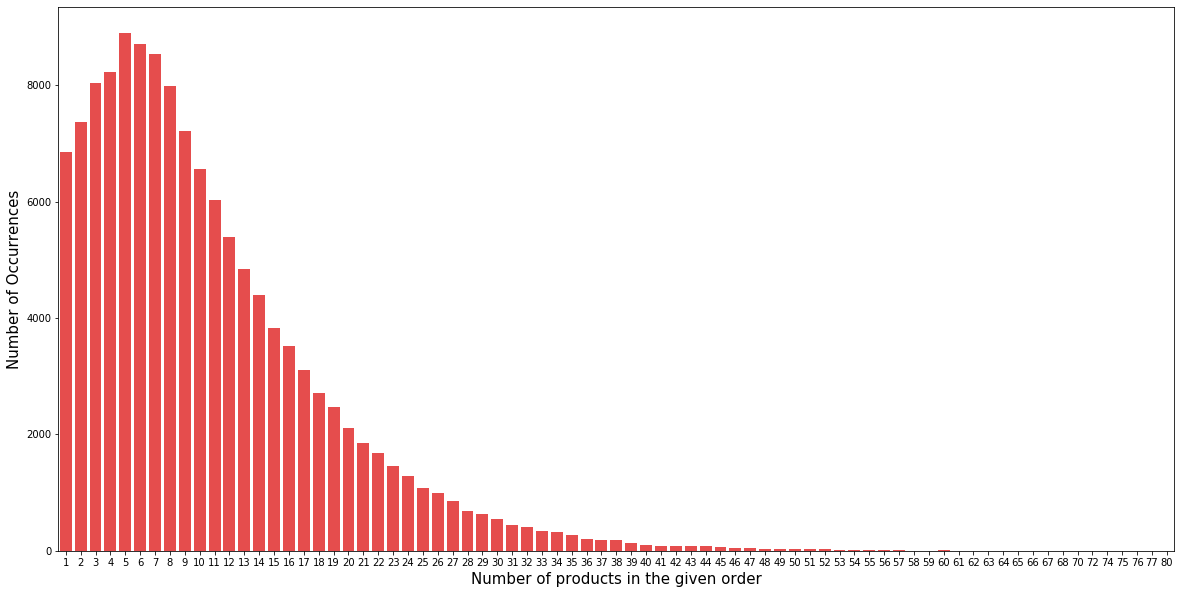

In [20]:
#No. of products per order on an average
grouped_df = df_order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(20,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color = 'red')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Number of products in the given order', fontsize=15)
plt.show()

It is observed that the customers generally buy 5-6 items per order.

#### Next, we merge the tables to get a better overview of our dataset

In [21]:
df_order_products_prior = pd.merge(df_order_products_prior, df_products, on='product_id', how='left')
df_order_products_prior = pd.merge(df_order_products_prior, df_aisles, on='aisle_id', how='left')
df_order_products_prior = pd.merge(df_order_products_prior, df_departments, on='department_id', how='left')
df_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


Let's have a look at the top grossing products

In [22]:
# Counting the total no of products purchased, i.e. the most popular products.
cnt_srs = df_order_products_prior['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


It is observed that customers prefer to buy vegetables and fruits. Analogous to this, we expect that the most used aisles should correspond to fruits. We are cross checking below:

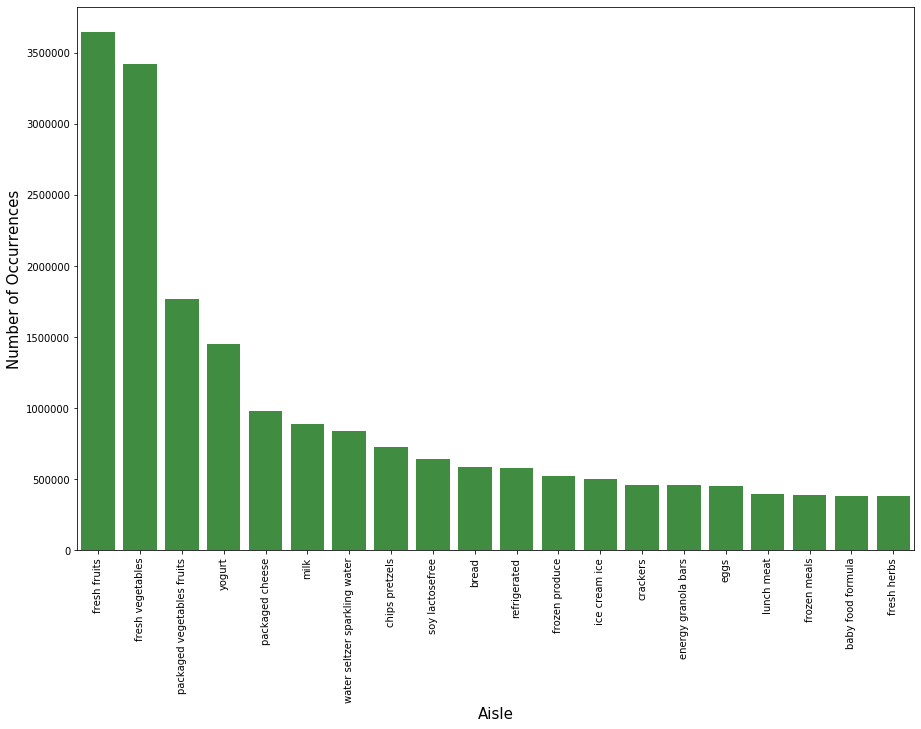

In [23]:
#Count for the sales according to the aisles
cnt_srs = df_order_products_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(15,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Aisle', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

* As we saw earlier, fresh fruits and fresh vegetables are the top grossing products and their aisles are the most shopped from.

#### Next, we analyze the distribution of product sales based on department

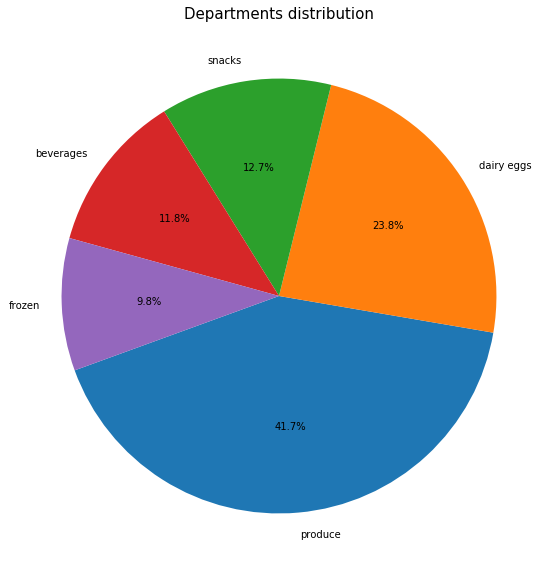

In [24]:
# Pie-chart for department-wise sales.
plt.figure(figsize=(10,10))
temp_series = df_order_products_prior['department'].value_counts().head(5)
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

* We observe that the produce department is selling the most. 

#### Analyzing the reorder ratio with respect to Department

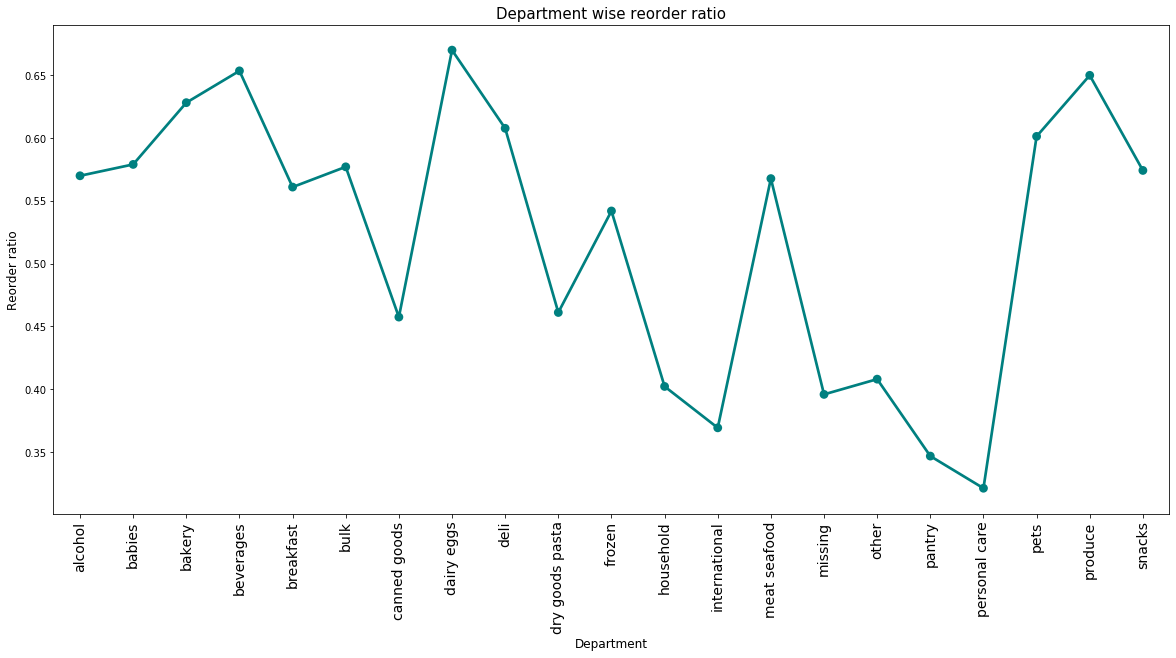

In [25]:

# This means if a certain product is ordered previously, what are the chances that it will be reordered again.
grouped_df = df_order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(20,9))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color='teal')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical',fontsize=14)
plt.show()

* Dairy eggs have the highest reorder ratio and personal care has the lowest reorder.

#### Next, we analyze if the reordering of a product depends on the order (sequence) in which it was added to the cart.

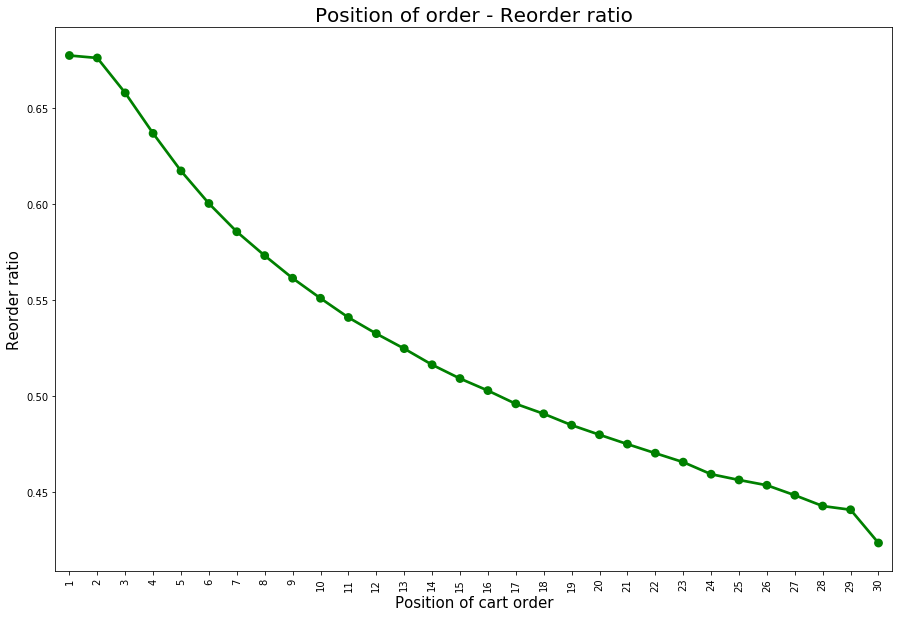

In [27]:
#Add to cart order - reorder ratio
# Here we are trying to understand if the order in which a product was added to the cart will affect it's chances of reordering
df_order_products_prior["add_to_cart_order_mod"] = df_order_products_prior["add_to_cart_order"].copy() # Making a copy of order_products_prior
df_order_products_prior["add_to_cart_order_mod"].loc[df_order_products_prior["add_to_cart_order_mod"]>30] = 30
grouped_df = df_order_products_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(15,10))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color='green')
plt.ylabel('Reorder ratio', fontsize=15)
plt.xlabel('Position of cart order', fontsize=15)
plt.title("Position of order - Reorder ratio", fontsize=20)
plt.xticks(rotation='vertical')
plt.show()

* So, the items people tend to reorder are generally put at the start rather than the end. The likelihood of reordering makes sense to us as well since we tend to first order all the products we used to buy frequently and then look out for the new products available afterwards.

#### Analyzing the reorder ratio in comparision to the hour and day of the week

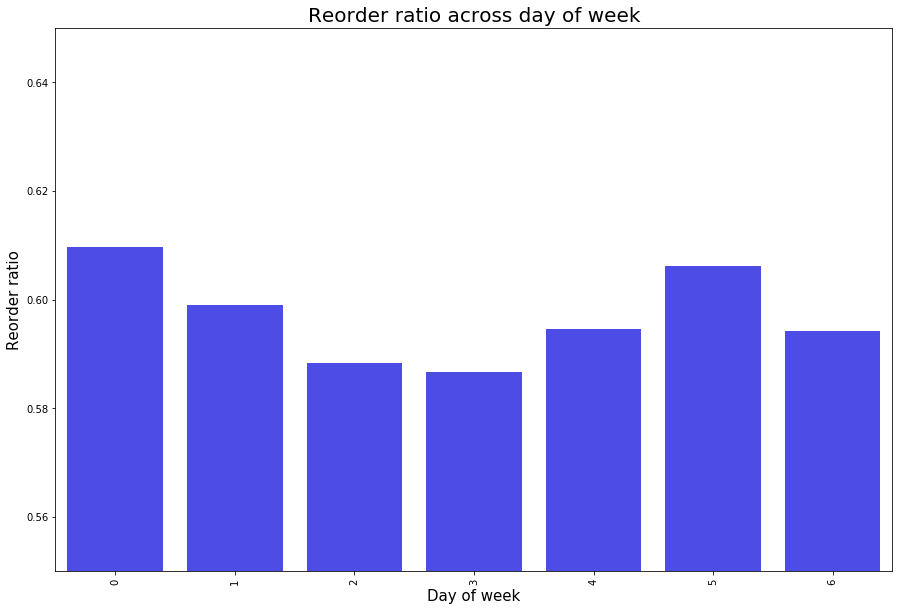

In [28]:
# Day of week
df_order_products_train = pd.merge(df_order_products_train, df_orders, on='order_id', how='left')
grouped_df = df_order_products_train.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(15,10))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color='blue')
plt.ylabel('Reorder ratio', fontsize=15)
plt.xlabel('Day of week', fontsize=15)
plt.title("Reorder ratio across day of week", fontsize=20)
plt.xticks(rotation='vertical')
plt.ylim(0.55, 0.65)
plt.show()

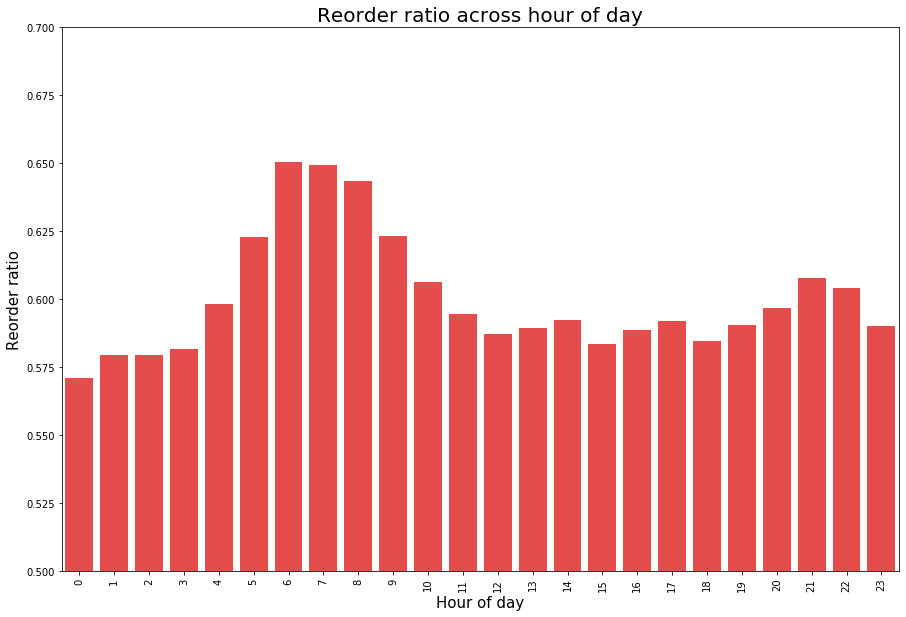

In [29]:
# Hour
grouped_df = df_order_products_train.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(15,10))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color='red')
plt.ylabel('Reorder ratio', fontsize=15)
plt.xlabel('Hour of day', fontsize=15)
plt.title("Reorder ratio across hour of day", fontsize=20)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

  It is seen that the reorder ratio is highest in the early hours of the day (7-8)

# **6. Word2Vec**

We know that the orders can be represented as sentences and product IDs can be represented as words. In the Word2Vec technique we will see if the model will learn any useful information about the products from the order history of all users, maybe in the future this can be used as input to a classifier that recommends products.

In [30]:
# Reading csv's
train_orders = pd.read_csv("order_products__train.csv")
prior_orders = pd.read_csv("order_products__prior.csv")
products = pd.read_csv("products.csv").set_index('product_id')

In [31]:
# Coverting product_id's to string
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

In [34]:
# Grouping by order_id
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

In [35]:
# Joining 
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
sentences = sentences.values

In [36]:
# Using the Word2Vec package from Gensim model
model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)

In [37]:
# Creating a list
vocab = list(model.wv.vocab.keys())

In [38]:
# Importing PCS from Ski-kit learn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

D:\Installations\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [39]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(21, 21))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

D:\Installations\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
D:\Installations\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


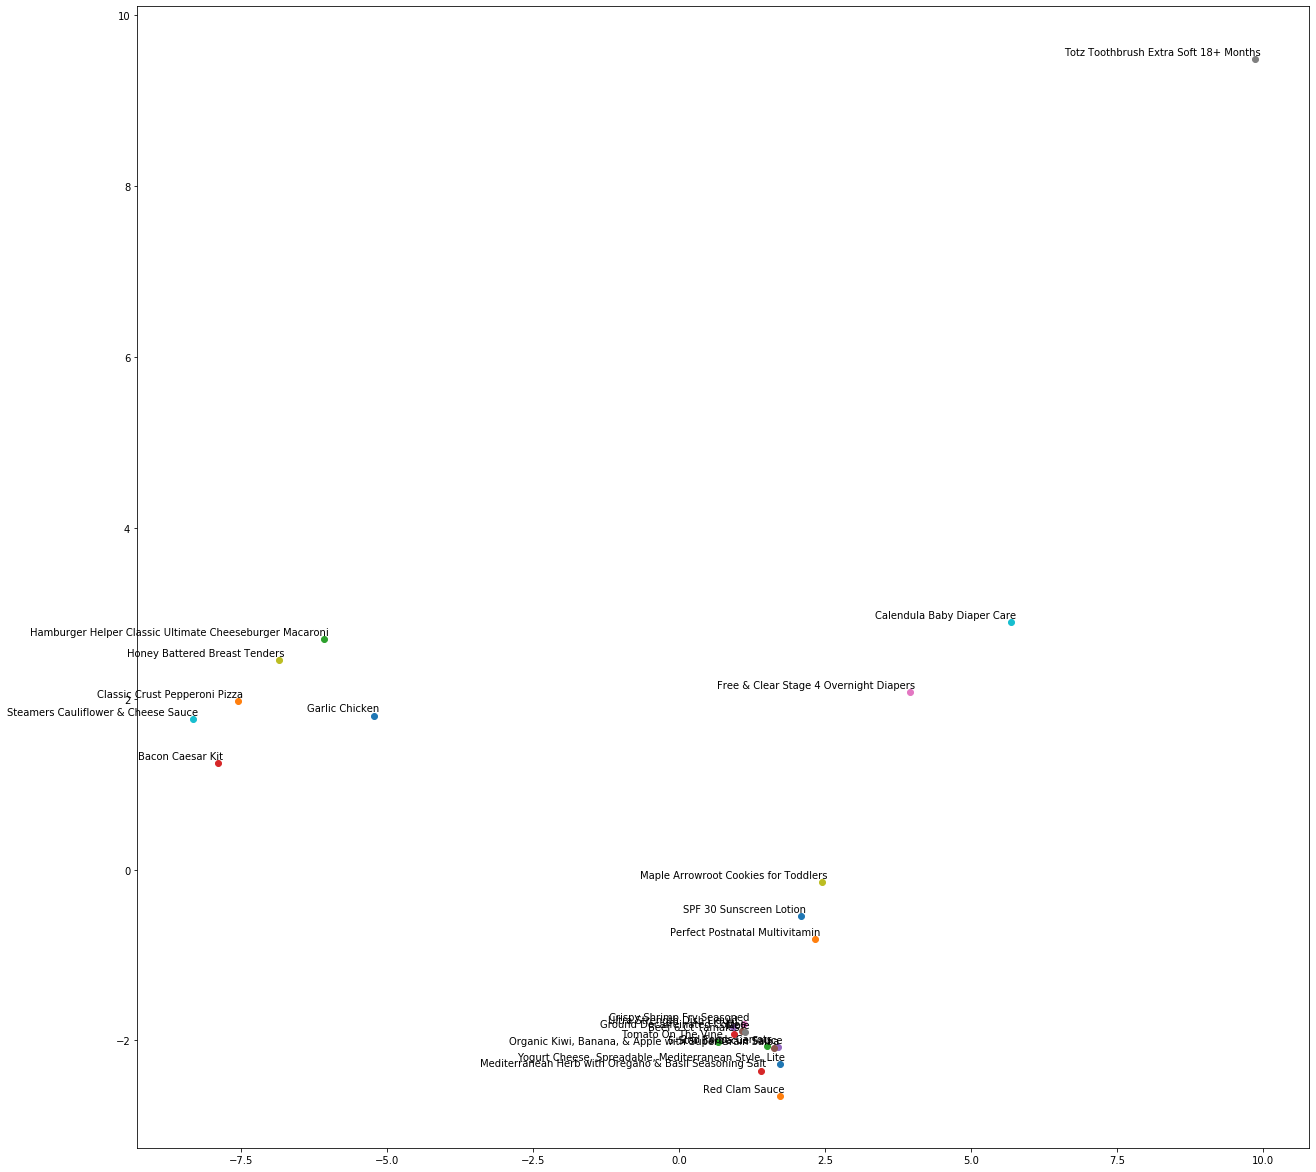

In [40]:
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=4):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

### The analysis is continued on the other two files.